# Interrogation du point d'accès SPARQL de DBPedia (en anglais)


Exploration des données liées aux 'économistes'


## Préparation

### Importer les librairies à utiliser

In [ ]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pprint
import csv
import ast

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [ ]:
### Importer un module de fonctions crée ad hoc
import sparql_functions as spqf

In [ ]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  
reload(spqf)

### Versionnement manuel de la base de donnée des requêtes

In [ ]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

In [ ]:
timestamp_formatted_for_file_name()

In [ ]:
### Définir les adresses des fichiers, l'existant et celui à créer
original_db = 'data/sparql_queries.db'

##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [ ]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(original_db, timestamped_db_copy)
copied_db

## Explorer Wikipedia / DBPedia

DBPedia est une base de données au format RDF réalisée par extraction de données semistructurées et structurées à partir (principalement) des Infobox et du résumé des pages de Wikipedia.

Les versions de DBPedia sont liées aux versions linguistiques de Wikipedia et dépendent de l'activité de 'chapitres' nationaux de DBPedia qui effectuent ces extractions. Il existe une [communauté (un 'chapitre')](https://www.data.gouv.fr/fr/datasets/dbpedia-fr-le-chapitre-francophone-de-dbpedia/) et une [version francophone](http://fr.dbpedia.org/).

Nous explorerons ici la version anglaise qui est la plus riche mais les différentes versions sont connectées, et on peut profiter de ces versions.

### Wikipedia: Les économistes, page "Economist"

*  https://en.wikipedia.org/wiki/Economist
*  https://en.wikipedia.org/wiki/Economics


### DBPedia : Economist

*  https://dbpedia.org/page/Economist  (an instance of the class [Person Function](https://dbpedia.org/ontology/PersonFunction) )
*  https://dbpedia.org/ontology/Economist  (a class)


*  https://dbpedia.org/page/Economics


### DBPedia SPARQL Endpoint

*  https://dbpedia.org/sparql
*  https://live.dbpedia.org/sparql (mis à jour en permanence, à utiliser pour les requêtes fédérées, i.e. la clause SERVICE)

Documentation : [SPARQL 1.1 Query Language](http://www.w3.org/TR/sparql11-query/)

### Keynes dans DBPedia

*  https://en.wikipedia.org/wiki/John_Maynard_Keynes
*  https://dbpedia.org/page/John_Maynard_Keynes



## Premières requêtes SPARQL

### Utiliser le point d'accès SPARQL de DBPedia

* Interroger le point d'accès de DBPedia 
  * Ouvrir dans une autre fenêtre du navigateur:
  * https://dbpedia.org/sparql
* Copier-coller le texte de la requête ci-dessous dans le navigateur:
* Exécuter et inspecter le résultat


NB : exécuter des requêtes directement sur le point SPARQL DBPedia permet de tester pour vérifier si elles fonctionnent correctement



In [ ]:
###  Définir la variable contenant la requête SPARQL
# Requête : toutes les propriétés concernant Keynes

q_1 = """

PREFIX dbpedia: <http://dbpedia.org/resource/>
SELECT ?p ?o WHERE {
dbpedia:John_Maynard_Keynes ?p ?o
}

"""

In [ ]:
###  Requête: toutes les propriétés ayant un texte en anglais en objet


q_2 = """

PREFIX dbpedia: <http://dbpedia.org/resource/>
SELECT ?p ?o WHERE {
dbpedia:John_Maynard_Keynes ?p ?o.
FILTER ( lang(?o) = "en" ) 
}

"""

In [ ]:
###  Requête: compter et regrouper les propriétés

q_3 = """

PREFIX dbpedia: <http://dbpedia.org/resource/>
SELECT ?p (COUNT(*) as ?eff) WHERE {
dbpedia:John_Maynard_Keynes ?p ?o.
}
GROUP BY ?p
ORDER BY DESC(?eff)

"""

In [ ]:
### Requête: inspecter le contenu des différentes propriétés, en les analysant une par une

# Astuce: ouvrir une nouvelle fenêtre du point d'accès SPARQL DBPedia
# A partir du résultat de la requête précédente, copier coller les proriétés et exécuter

q_4 = """

PREFIX dbpedia: <http://dbpedia.org/resource/>
SELECT ?o WHERE {
dbpedia:John_Maynard_Keynes <http://dbpedia.org/ontology/birthPlace> ?o.
}

"""

In [ ]:
### Requête : compter les instances (personnes) de la classe dbo:Economist

q_5 = """
PREFIX  dbo:  <http://dbpedia.org/ontology/>

SELECT  (COUNT(*) AS ?freq)
WHERE
{ ?person  a dbo:Economist.
}

"""

### Exécuter les mêmes requêtes depuis le carnet Jupyter

In [ ]:
### Librairie SPARQLWrapper, indiquer sur quel point d'accès SPARQL exécuter la requête
sparql = SPARQLWrapper("https://dbpedia.org/sparql") ##, returnFormat=RDFXML)

In [ ]:
### Mettre en argument de la fonction setQuery, qui définit la requête, le nom de la variable correspondante
#  On définit le format du resultat (JSON), puis on effectue la requête en ligne 
# et on inspecte le type de résultat: le résultat en JSON a été transformé en une variable 'dictionnaire'

sparql.setQuery(q_3)
sparql.setReturnFormat(JSON)
rc = sparql.queryAndConvert()
type(rc)

In [ ]:
### Inspecter le résultat complet
# Activer 'enable scrolling outputs' dans le carnet Jupyter (click droit sur le résultat)
rc

In [ ]:
### En alternative à la requête précédente, transformer le résultat JSON en texte et inspecter les 500 premiers caractères
str(rc)[:500]

#### Documentation JSON / Python _dictionary_

* https://docs.python.org/3/library/json.html
* https://docs.python.org/3/tutorial/datastructures.html#dictionaries


In [ ]:
### Nombre de lignes du résultat, utiliser la structure JSON (dictionnaire en Python)
len(rc['results']['bindings'])

In [ ]:
# Inspecter les trois premières lignes du résultat
i = 0
for l in rc['results']['bindings']:
    if i < 3:
        print(l)
        i += 1

In [ ]:
r = [print(l) for l in spqf.sparql_result_to_list(rc)]

## Effectifs et propriétés de 'economist' et 'economics'

### Stocker les requêtes dans une base de données SQLite


*  Afin de ne pas surcharger le carnet, les requêtes SPARQL et les résultats sont stockées dans une base de données SQLite.
*  Elle se trouve dans le dossier _data/sparql_queries.db_ .
*  On peut l'ouvrir et l'éditer avec le logiciel SQLiteStudio, cf. les indications de [cette page](http://phn-wiki.ish-lyon.cnrs.fr/doku.php?id=intro_histoire_numerique:modelisation_bases_donnees)


#### Manière de procéder

* Préparer la requête directement dans l'éditeur du point d'accès SPARQ original, dans ce cas: https://dbpedia.org/sparql
* Si nécessaire, valider et formater les requêtes dans ces plateformes:
  *  https://linked.bodc.ac.uk/validate/query
  *  http://sparql.org/query-validator.html
* Copier ensuite la requête dans une nouvelle ligne de la base de données, table _query_
* Ajouter un titre, un descriptif, l'adresse du point d'accès SPARQL dans la nouvelle ligne de la base de données
* Choisir la ligne à exécuter et retenir les numéro de sa clé primaire (_pk_query_)


In [ ]:
### Inspecter les requêtes existantes

# connnexion à la base de données
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c = conn.cursor()
c.execute('SELECT pk_query, label, description, sparql_endpoint FROM query')
r_all = c.fetchall()

# fermer la connexion
conn.close()
r_all

In [ ]:
### Définir la ligne de la base de données à utiliser (inspécter préalablement la base de données)
pk_query = ('4')

# connnexion à la base de données
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c = conn.cursor()
c.execute('SELECT * FROM query WHERE pk_query = ?', pk_query)
rc = c.fetchone()

# fermer la connexion
conn.close()

# imprimer et inspecter le résultat
pprint.pprint(rc)

In [ ]:
print(rc[4],'\n---\n',rc[5])

### Exécuter les requêtes SPARQL en utilisant les fonctions-utilisateur

In [ ]:
### Exécuter la requête SPARQL enveloppée par cette fonction, 
# elle se trouve dans le biliothèque-utilisateur _sparql_functions.py_
# le premier paramètre correspond au point d'accès SPARQL, le deuxième à la requête
qr = spqf.get_json_sparql_result(rc[4],rc[5])

In [ ]:
# Nombre de lignes de la réponse
len(qr['results']['bindings'])

In [ ]:
# Inspecter les trois premières lignes
i = 0
for l in qr['results']['bindings']:
    if i < 3:
        print(l)
        i += 1

In [ ]:
# Transformer le résultat en liste en utilisant une autre fonction de la bibliothèque utilisateur
r = [l for l in spqf.sparql_result_to_list(qr)]
# r

In [ ]:
# inspecter une seule ligne de la liste (de listes)
r[0]

### Stocker le résultat dans la base de données SQLite

In [ ]:
### OPTIONNEL : si souhaité, stocker la réponse du point d'accès SPARQL dans la table 'result' de la base de données 

conn = sql.connect(original_db)
c = conn.cursor()
values = (pk_query, str(qr),timestamp_formatted_for_file_name())

# https://www.techonthenet.com/sqlite/functions/now.php
c.execute("INSERT INTO result (fk_query, result, tmsp) VALUES (?,?,?)", values)
# valider l'insertion et fermer la base de données
## désactivé ## conn.commit()
conn.close()

In [ ]:
### Inspecter le résultat d'une requête après insertion, une fois l'insert ci-dessus effectué

# Définir la ligne de la base de données à chercher (inspécter préalablement la base de données)
pk_result = ('4')

# connnexion à la base de données
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c = conn.cursor()
c.execute('SELECT * FROM result WHERE pk_result = ?', pk_result)
result_q = c.fetchone()

# fermer la connexion
conn.close()
# result_q[3]

In [ ]:
### Transform string to dict
## Doc.:
# https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
d = ast.literal_eval(result_q[3])
type(d)

In [ ]:
# Transformer le résultat en liste en utilisant une autre fonction de la bibliothèque utilisateur
r = [l for l in spqf.sparql_result_to_list(d)]
print(len(r))
r

### Inspecter les années de naissance et compter le nombre de naissances par années

In [ ]:
# Explore
listeAnnees = []
for l in r:
    listeAnnees.append(int(l[1]))

In [ ]:
listeAnnees[:10]

In [ ]:
min(listeAnnees), max(listeAnnees)

In [ ]:
listeAnnees.sort()

In [ ]:
listeAnnees[:10]

### Tester le comportement des graphiques si les données sont lacunaires

In [160]:
### Grâce à l'opération modulo on ne retient que les années qui sont multiple de 4
fakeList = [a for a in listeAnnees if a % 4 == 0]
fakeList[10:20]

[1860, 1864, 1864, 1868, 1872, 1876, 1876, 1880, 1880, 1880]

In [162]:
# Compter les naissances par année
counterFakeListeAnnees = Counter(fakeList)
groupedFakeListeAnnees = list(zip(counterFakeListeAnnees.keys(), counterFakeListeAnnees.values()))
groupedFakeListeAnnees[:10]

[(1808, 1),
 (1828, 1),
 (1840, 1),
 (1844, 2),
 (1848, 1),
 (1852, 3),
 (1860, 2),
 (1864, 2),
 (1868, 1),
 (1872, 1)]

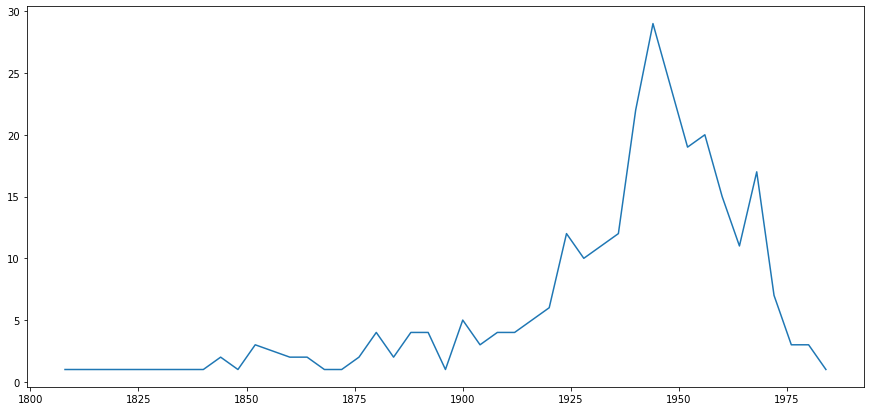

In [163]:
objects = [l[0] for l in groupedFakeListeAnnees]
eff = [l[1] for l in groupedFakeListeAnnees]

plt.figure(figsize=(15,7))
plt.plot(objects, eff)

<BarContainer object of 38 artists>

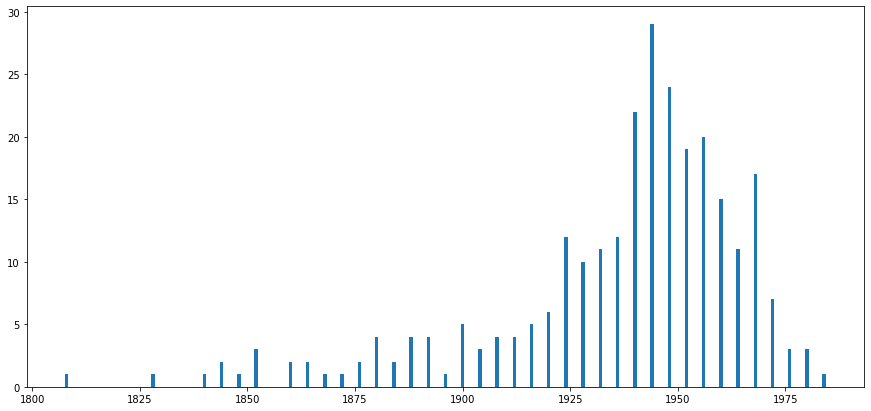

In [164]:
objects = [l[0] for l in groupedFakeListeAnnees]
eff = [l[1] for l in groupedFakeListeAnnees]

plt.figure(figsize=(15,7))
plt.bar(objects, eff)

In [165]:
start = 1801
end = 1992

lYears = []
year = start
while year < end:
    c = 0
    for y in fakeList:
        if y == year:
            c += 1
    lYears.append([year, c]) 
    year += 1
lYears [:40]    

[[1801, 0],
 [1802, 0],
 [1803, 0],
 [1804, 0],
 [1805, 0],
 [1806, 0],
 [1807, 0],
 [1808, 1],
 [1809, 0],
 [1810, 0],
 [1811, 0],
 [1812, 0],
 [1813, 0],
 [1814, 0],
 [1815, 0],
 [1816, 0],
 [1817, 0],
 [1818, 0],
 [1819, 0],
 [1820, 0],
 [1821, 0],
 [1822, 0],
 [1823, 0],
 [1824, 0],
 [1825, 0],
 [1826, 0],
 [1827, 0],
 [1828, 1],
 [1829, 0],
 [1830, 0],
 [1831, 0],
 [1832, 0],
 [1833, 0],
 [1834, 0],
 [1835, 0],
 [1836, 0],
 [1837, 0],
 [1838, 0],
 [1839, 0],
 [1840, 1]]

In [166]:
l5Years = []
start = 1801
end = 1992

l5Years = []
year = start
while year < end:
    l5Years.append(year) 
    year += 5
l5Years [:10]    

[1801, 1806, 1811, 1816, 1821, 1826, 1831, 1836, 1841, 1846]

In [ ]:
# Distribution par année

objects = [l[0] for l in lYears]
eff = [l[1] for l in lYears]

p1 = plt.bar(objects, eff)

plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Naissances par année')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Distribution des naissances par année et par période de 20 ans

#### Regroupement des vraies valeurs par année

In [168]:
# Compter les naissances par année
counterListeAnnees = Counter(listeAnnees)
groupedListeAnnees = list(zip(counterListeAnnees.keys(), counterListeAnnees.values()))

In [182]:
groupedListeAnnees[75:90]

[(1908, 4),
 (1909, 1),
 (1910, 8),
 (1911, 5),
 (1912, 4),
 (1913, 4),
 (1914, 10),
 (1915, 5),
 (1916, 5),
 (1917, 8),
 (1918, 7),
 (1919, 8),
 (1920, 6),
 (1921, 12),
 (1922, 9)]

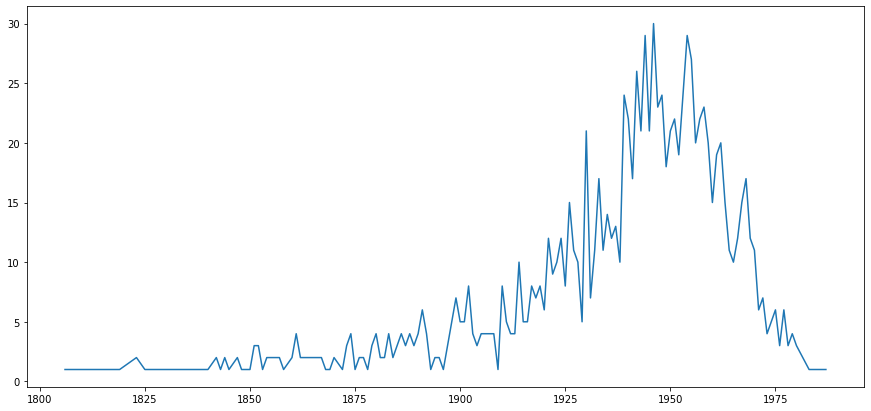

In [179]:
objects = [l[0] for l in groupedListeAnnees]
eff = [l[1] for l in groupedListeAnnees]

plt.figure(figsize=(15,7))
plt.plot(objects, eff)

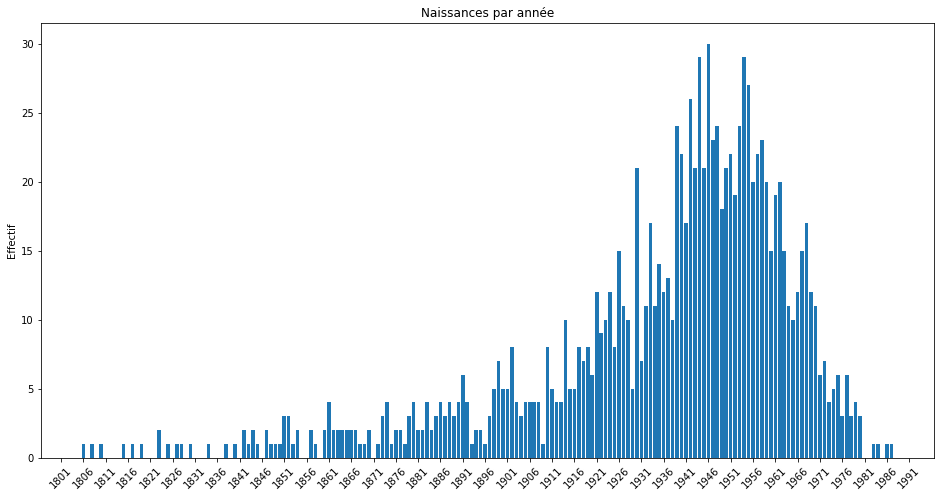

In [172]:
# Distribution par année

objects = [l[0] for l in groupedListeAnnees]
eff = [l[1] for l in groupedListeAnnees]

p1 = plt.bar(objects, eff)

plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Naissances par année')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


#### Regroupement des valeurs par 20 ans

In [173]:
### Créer la liste des périodes de 20 ans, i.e. la liste de la première année de chaque période
d20List = []
period = 20
d_start = 1801
i = 0
d20List.append(d_start)

while i < 10:
    d_start = d_start + period
    d20List.append(d_start)
    i += 1

In [174]:
print(d20List[:2])
min(d20List), max(d20List)

[1801, 1821]


(1801, 2001)

In [176]:
# Regroupement par période de 20 ans
i20List = []
for i in d20List:
    i_n = 0
    for l in groupedListeAnnees:
        if l[0] >= i and l[0] < (i + 20):
            i_n = i_n + l[1]
    i20List.append([i, i_n])        

In [177]:
i20List[5]

[1901, 107]

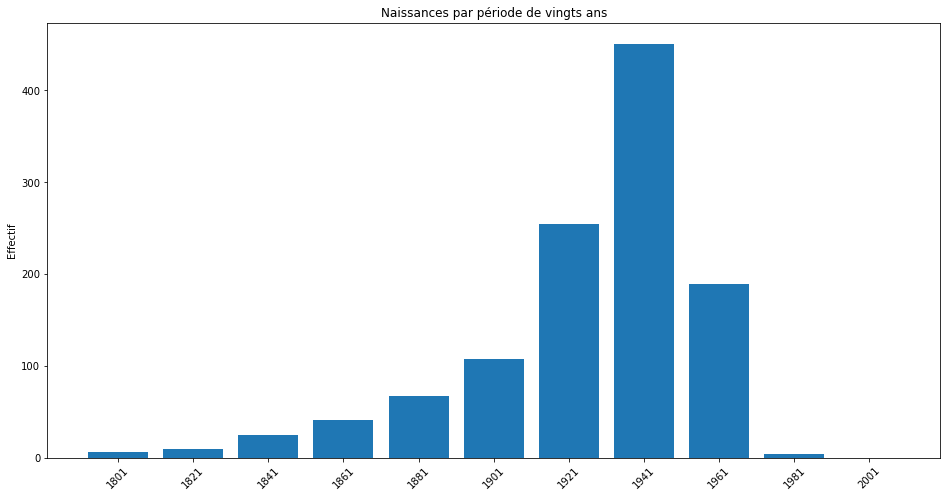

In [183]:
# Distribution par période de 20 ans

objects = [str(l[0]) for l in i20List]
eff = [l[1] for l in i20List]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingts ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


## Résultats pour inspection des propriétés disponibles

Requêtes effectuées le 21 février 2021

#### Economist (ontology) : https://dbpedia.org/ontology/Economist
<code>
['in', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', '1570']
['out', 'http://www.w3.org/2000/01/rdf-schema#label', '18']
['out', 'http://www.w3.org/2000/01/rdf-schema#comment', '6']
['out', 'http://www.w3.org/2002/07/owl#equivalentClass', '2']
['out', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', '2']
['out', 'http://www.w3.org/ns/prov#wasDerivedFrom', '2']
['out', 'http://www.w3.org/2000/01/rdf-schema#subClassOf', '2']
['out', 'http://www.w3.org/2007/05/powder-s#describedby', '1']
['in', 'http://open.vocab.org/terms/defines', '1']
['out', 'http://www.w3.org/2000/01/rdf-schema#isDefinedBy', '1']
['in', 'http://open.vocab.org/terms/describes', '1']
    </code>


#### Economist (resource): https://dbpedia.org/resource/Economist

<code>
['in', 'http://dbpedia.org/ontology/wikiPageWikiLink', '3667']
['in', 'http://dbpedia.org/ontology/occupation', '380']
['in', 'http://dbpedia.org/ontology/profession', '356']
['in', 'http://dbpedia.org/property/profession', '314']
['in', 'http://dbpedia.org/property/occupation', '248']
['out', 'http://dbpedia.org/ontology/wikiPageWikiLink', '91']
['out', 'http://www.w3.org/2002/07/owl#sameAs', '61']
['in', 'http://dbpedia.org/ontology/academicDiscipline', '23']
['out', 'http://www.w3.org/2000/01/rdf-schema#label', '21']
['out', 'http://www.w3.org/2000/01/rdf-schema#comment', '20']
['out', 'http://dbpedia.org/ontology/abstract', '20']
['in', 'http://dbpedia.org/property/field', '19']
['out', 'http://dbpedia.org/property/wikiPageUsesTemplate', '15']
['in', 'http://dbpedia.org/ontology/field', '9']
['in', 'http://dbpedia.org/property/fields', '8']
['in', 'http://dbpedia.org/ontology/knownFor', '5']
['in', 'http://dbpedia.org/property/discipline', '4']
['in', 'http://dbpedia.org/ontology/wikiPageRedirects', '3']
['out', 'http://purl.org/dc/terms/subject', '3']
['out', 'http://dbpedia.org/ontology/wikiPageExternalLink', '2']
['in', 'http://dbpedia.org/property/schoolTradition', '2']
['out', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', '2']
['in', 'http://dbpedia.org/ontology/education', '2']
['out', 'http://dbpedia.org/ontology/wikiPageRevisionID', '1']
['out', 'http://dbpedia.org/ontology/thumbnail', '1']
['out', 'http://dbpedia.org/ontology/wikiPageID', '1']
['out', 'http://purl.org/dc/terms/isPartOf', '1']
['in', 'http://dbpedia.org/property/office', '1']
['in', 'http://dbpedia.org/ontology/institution', '1']
['in', 'http://dbpedia.org/property/knownFor', '1']
['in', 'http://dbpedia.org/property/contributions', '1']
['out', 'http://xmlns.com/foaf/0.1/isPrimaryTopicOf', '1']
['in', 'http://dbpedia.org/property/otheroccupation', '1']
['in', 'http://dbpedia.org/ontology/influencedBy', '1']
['in', 'http://xmlns.com/foaf/0.1/primaryTopic', '1']
['in', 'http://dbpedia.org/ontology/wikiPageDisambiguates', '1']
['in', 'http://dbpedia.org/property/laterwork', '1']
['in', 'http://dbpedia.org/ontology/discipline', '1']
['out', 'http://www.w3.org/ns/prov#wasDerivedFrom', '1']
['in', 'http://dbpedia.org/property/education', '1']
['out', 'http://www.w3.org/2000/01/rdf-schema#seeAlso', '1']
['out', 'http://xmlns.com/foaf/0.1/depiction', '1']
['out', 'http://dbpedia.org/ontology/wikiPageLength', '1']
['out', 'http://www.w3.org/2004/02/skos/core#closeMatch', '1']

</code>    




#### Economics (https://dbpedia.org/resource/Economics)


<code>
['in', 'http://dbpedia.org/ontology/wikiPageWikiLink', '8925']
['out', 'http://dbpedia.org/ontology/wikiPageWikiLink', '507']
['in', 'http://dbpedia.org/ontology/academicDiscipline', '356']
['in', 'http://dbpedia.org/property/field', '230']
['in', 'http://dbpedia.org/property/discipline', '175']
['in', 'http://dbpedia.org/ontology/field', '128']
['out', 'http://www.w3.org/2002/07/owl#sameAs', '115']
['in', 'http://dbpedia.org/property/fields', '86']
['in', 'http://dbpedia.org/property/subject', '67']
['in', 'http://dbpedia.org/ontology/nonFictionSubject', '61']
['in', 'http://dbpedia.org/ontology/education', '53']
['out', 'http://dbpedia.org/property/wikiPageUsesTemplate', '44']
['in', 'http://dbpedia.org/ontology/wikiPageRedirects', '43']
['in', 'http://dbpedia.org/property/genre', '30']
['in', 'http://dbpedia.org/ontology/mainInterest', '29']
['in', 'http://dbpedia.org/property/mainInterests', '29']
['in', 'http://dbpedia.org/ontology/literaryGenre', '26']
['out', 'http://dbpedia.org/ontology/wikiPageExternalLink', '25']
['out', 'http://www.w3.org/2000/01/rdf-schema#comment', '22']
['out', 'http://dbpedia.org/ontology/abstract', '22']
['out', 'http://www.w3.org/2000/01/rdf-schema#label', '22']
['in', 'http://dbpedia.org/ontology/knownFor', '21']
['in', 'http://dbpedia.org/ontology/almaMater', '18']
['in', 'http://dbpedia.org/ontology/occupation', '17']
['in', 'http://dbpedia.org/property/education', '16']
['in', 'http://dbpedia.org/property/skills', '16']
['in', 'http://dbpedia.org/ontology/profession', '16']
['in', 'http://dbpedia.org/ontology/genre', '14']
['in', 'http://purl.org/dc/elements/1.1/subject', '12']
['in', 'http://dbpedia.org/property/profession', '11']
['in', 'http://dbpedia.org/property/knownFor', '10']
['in', 'http://dbpedia.org/property/category', '7']
['in', 'http://dbpedia.org/property/focus', '5']
['in', 'http://dbpedia.org/ontology/type', '5']
['in', 'http://dbpedia.org/property/industry', '5']
['in', 'http://www.w3.org/2000/01/rdf-schema#seeAlso', '4']
['in', 'http://dbpedia.org/property/type', '4']
['in', 'http://dbpedia.org/property/occupation', '3']
['in', 'http://dbpedia.org/property/researchField', '3']
['in', 'http://dbpedia.org/ontology/industry', '3']
['in', 'http://dbpedia.org/property/almaMater', '3']
['out', 'http://www.w3.org/2000/01/rdf-schema#seeAlso', '3']
['in', 'http://dbpedia.org/property/subjects', '3']
['out', 'http://www.w3.org/2004/02/skos/core#closeMatch', '3']
['in', 'http://dbpedia.org/property/schoolTradition', '2']
['in', 'http://dbpedia.org/ontology/award', '2']
['out', 'http://purl.org/dc/terms/subject', '2']
['in', 'http://dbpedia.org/ontology/wikiPageDisambiguates', '2']
['out', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', '2']
['in', 'http://www.w3.org/2002/07/owl#differentFrom', '2']
['out', 'http://dbpedia.org/ontology/wikiPageRevisionID', '1']
['out', 'http://dbpedia.org/ontology/thumbnail', '1']
['out', 'http://dbpedia.org/ontology/wikiPageID', '1']
['out', 'http://purl.org/dc/terms/isPartOf', '1']
['in', 'http://dbpedia.org/property/faculty', '1']
['in', 'http://dbpedia.org/property/group', '1']
['in', 'http://dbpedia.org/ontology/picture', '1']
['in', 'http://dbpedia.org/property/skillsTested', '1']
['out', 'http://xmlns.com/foaf/0.1/isPrimaryTopicOf', '1']
['out', 'http://dbpedia.org/property/onlinebooks', '1']
['in', 'http://dbpedia.org/property/scope', '1']
['in', 'http://dbpedia.org/property/topics', '1']
['out', 'http://dbpedia.org/property/label', '1']
['in', 'http://xmlns.com/foaf/0.1/primaryTopic', '1']
['in', 'http://dbpedia.org/property/purpose', '1']
['in', 'http://dbpedia.org/property/subDiscipline', '1']
['out', 'http://dbpedia.org/property/by', '1']
['out', 'http://www.w3.org/ns/prov#wasDerivedFrom', '1']
['in', 'http://dbpedia.org/property/activitySector', '1']
['in', 'http://dbpedia.org/property/classesOffered', '1']
['out', 'http://dbpedia.org/property/about', '1']
['out', 'http://xmlns.com/foaf/0.1/depiction', '1']
['out', 'http://dbpedia.org/ontology/wikiPageLength', '1']
['in', 'http://dbpedia.org/property/vp', '1']
['out', 'http://dbpedia.org/property/others', '1']
['in', 'http://dbpedia.org/ontology/service', '1']
</code>    